# load necessary libraries & other preparations:

In [13]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile#, Aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error

from qiskit.visualization import plot_histogram

import numpy as np

import networkx as nx

from multiprocessing import Pool
import tqdm
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Quantum Fourier Transform

In [2]:
def QuantumFourierTransform(digits: int):
    
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegY)

    for i, q in enumerate(QRegY):
        QC.h(q)

        theta = np.pi / 2
        for r in QRegY[i + 1:]:
            QC.cp(theta, r, q)
            theta /= 2
    
    return QC.to_gate()

## noise model based on IonQ's Aria specifications:
depolarizing error probability is probabilities adjusted from thermal noise infidelity: $p = e^{-t/T_2}$ with gate time for $t$

In [3]:
# error probabilities
p_meas = 0.39/100
p_reset = 0.39/100
p_gate1 = 0.06/100
p_gate2 = 0.6/100

# thermal relaxation error (nanosecond time)
T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
T2 = 1e9

time_meas = np.random.choice(range(600, 700), 10, replace=False)
time_u1 = 0 # virtual gate
time_gate1 = 135e3 # u1 and u2
time_gate2 = 600e3 # 2 qubit gate

# thermal relaxation error
ther_u1  = [thermal_relaxation_error(t1 * 1e9, T2, time_u1)
              for t1 in T1s]
ther_gate1  = [thermal_relaxation_error(t1 * 1e9, T2, time_gate1)
              for t1 in T1s]
ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, T2, time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, T2, time_gate2))
              for t1a in T1s]
               for t1b in T1s]

# depolarizing error
dep_reset = depolarizing_error(p_reset, 1)
dep_gate1 = depolarizing_error(p_gate1 - 1.34990888e-4, 1)
dep_gate2 = depolarizing_error(p_gate2 - 5.99820036e-4, 2)

# readout error
er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

# creating the noise model
fake_aria = NoiseModel()

for j in range(10):
    fake_aria.add_quantum_error(ther_u1[j].compose(dep_gate1), "u1", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u2", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u3", [j])
    for k in range(10):
        fake_aria.add_quantum_error(ther_gate2[j][k].compose(dep_gate2), "cx", [j, k])
fake_aria.add_all_qubit_quantum_error(dep_reset, "reset")
fake_aria.add_all_qubit_readout_error(er_meas)

## graph plotter

In [4]:
#graph plotter
def createGraph(GraphLaplacian: list[list[int]]):
    Edges = []
    for i, row in enumerate(GraphLaplacian):
        for j, v in enumerate(row[:i]):
            if v == - 1:
                Edges.append([j, i])
    Graph = nx.Graph()
    Graph.add_edges_from(Edges)
    nx.draw_networkx(Graph)

# circuits:

## cost/energy oracle:**bold text** $U_C | x \rangle | y \rangle = | x \rangle | y - C (x) \rangle$

In [5]:
def EnergyOracle(QuadraticForm: list[list[int]], digits: int, y: int):

    QRegX = QuantumRegister(len(QuadraticForm))
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegX, QRegY)

    QFT = QuantumFourierTransform(digits)
    QC.append(QFT, QRegY)
    
    # Phasers
    for i, v in enumerate(QuadraticForm):
        theta = - np.pi * v[i]
        # QRegY is reversed below to save on swaps in QFT
        for q in reversed(QRegY):
            QC.cp(theta, QRegX[i], q)
            theta /= 2

        for j, w in enumerate(QuadraticForm[i][i + 1:]):
            if w != 0:
                theta = - 2 * np.pi * w
                # QRegY is reversed below to save on swaps in QFT
                for q in reversed(QRegY):
                    QC.mcp(theta, [QRegX[i], QRegX[i + 1 + j]], q)
                    theta /= 2

    QC.append(QFT.inverse(), QRegY)

    return QC.to_gate()

## Grover fixed point circuit, $S_L = G \left( \alpha_l, \beta_l \right) \cdots G \left( \alpha_1, \beta_1 \right)$

In [6]:
def GroverFixedPointGate(QuadraticForm: list[list[int]], digits: int, delta: float, RootLambda: float):

    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1

    gamma = np.sqrt(1 - pow(np.cosh(np.arccosh(1 / delta) / (2 * l + 1)), - 2))

    angles = [2 * np.arctan(1 / (gamma * np.tan(2 * np.pi * j / (2 * l + 1)))) for j in range(1, l + 1)]
    
    CostGate = EnergyOracle(QuadraticForm, digits, y)
    CostGate_inverse = CostGate.inverse()

    QRegX = QuantumRegister(len(QuadraticForm), "x")
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY)

    for _, (alpha, beta) in enumerate(zip(angles, reversed(angles))):

        # S_t (beta)
        QC.append(CostGate, QRegX[:] + QRegY[:])
        QC.p(beta, QRegY[0])
        QC.append(CostGate_inverse, QRegX[:] + QRegY[:])
        
        # S_s (alpha)
        QC.h(QRegX)
        QC.x(QRegX)
        QC.mcp(alpha, QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.h(QRegX)

    return QC.to_gate()

## Grover assisted QAOA

if `angles = []`, then it is just a Grover Fixed Point Search

if $\delta \notin (0, 1)$, then it is just a vanilla QAOA

In [7]:
def GroverPlusQAOA(QuadraticForm: list[list[int]], digits: int, y: int, angles: list[list[float]], delta: float, Lambda: float, NumberOfShots: int, noise: bool):

    # one quantum/classical register pair for each vertex
    QRegX = QuantumRegister(len(QuadraticForm), "x")
    ClRegX = ClassicalRegister(len(QuadraticForm), "cl-x")

    # quantum registers to digitize y
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY, ClRegX)

    for q in QRegX:
        QC.initialize([1, 0], q)

    for i, q in enumerate(QRegY):
        # y - 1 is used so that states with f(x) >= y are flagged
        bit = ((y-1)>>(digits-i-1))&1
        QC.initialize([1 - bit, bit], q)

    QC.h(QRegX)

    if 0 < delta < 1:
        Grover = GroverFixedPointGate(GraphLaplacian, digits, delta, Lambda)
        QC.append(Grover, QRegX[:] + QRegY[:])
    
    for beta, gamma in angles:
        # Cost
        for i, q in enumerate(QRegX):
            if QuadraticForm[i][i] != 0:
                QC.p(QuadraticForm[i][i] * gamma * np.pi / BetaGridSize, q)
            for j, r in enumerate(QRegX[:i]):
                if GraphLaplacian[i][j] != 0:
                    QC.cp(QuadraticForm[i][j] * 2 * gamma * np.pi / BetaGridSize, q, r)

        # Mixer
        QC.rx(beta * np.pi / BetaGridSize, QRegX)
        # IonQ recommendation is to use RZ gates instead of RX
        # QC.h(QRegX)
        # QC.rz(beta * np.pi / BetaGridSize, QRegX)
        # QC.h(QRegX)

    QC.measure(QRegX, ClRegX)

    # simulation
    if noise:
        simulator = AerSimulator(noise_model=fake_aria)
    else:
        simulator = AerSimulator()
    transpiled_QC = transpile(QC, simulator)    
    counts = simulator.run(transpiled_QC, shots=NumberOfShots).result().get_counts(transpiled_QC)

    M = 0
    approx_max = 0
    approx_max_conf = np.zeros(len(QuadraticForm), dtype=int)
    for s in counts:
        conf = np.array([int(x) for x in reversed(s)])
        m = np.matmul(conf, np.matmul(QuadraticForm, np.transpose(conf)))
        M += m * counts[s]
        if m > approx_max:
            approx_max = m
            approx_max_conf = conf
    
    M /= NumberOfShots

    return [M, angles, approx_max, approx_max_conf, counts]

# parameters & testing:

In [14]:
# independent inputs

# graph size
NumberOfVerticies = 10 # must be <= 18 to fit in Aria (can add one more later)
edge_probability = 0.5

# Grover
Lambda = 0.11   # ratio of good states to all states
delta = 0.1     # approximation parameter

'''
# this is for the QAOA grid
p = 2
BetaGridSize = 4
jump = 2

# from the input we compute

# sets of QAOA angles
grid = []
for beta in range(1, BetaGridSize):
    for gamma in range(1, 2 * BetaGridSize):
        grid.append([[beta, gamma]])

jumps = [[0, 0]]
for x in range(1, jump + 1):
    jumps.append([x, 0])
    jumps.append([- x, 0])
    jumps.append([0, x])
    jumps.append([0, - x])
    for y in range(1, jump + 1 - x):
        jumps.append([x, y])
        jumps.append([x, - y])
        jumps.append([- x, y])
        jumps.append([- x, - y])

GridPaths = grid.copy()
for i in range(1, p):
    NewGridPaths = []
    for paths in GridPaths:
        for jump in jumps:
            beta = (paths[-1][0] + jump[0])%BetaGridSize
            gamma = (paths[-1][1] + jump[1])%(2 * BetaGridSize)
            if beta != 0 and gamma != 0:
                NewGridPaths.append(paths + [[beta, gamma]])
    GridPaths = NewGridPaths
'''


# random, connected graph
disconnected = True
while disconnected:
    GraphLaplacian = np.zeros((NumberOfVerticies, NumberOfVerticies), dtype=int)
    for i in range(NumberOfVerticies):
        for j in range(i + 1, NumberOfVerticies):
            if np.random.rand() < edge_probability:
                GraphLaplacian[i][j] = GraphLaplacian[j][i] = - 1
        GraphLaplacian[i][i] = - np.sum(GraphLaplacian[i])
    disconnected = (NumberOfVerticies != np.linalg.matrix_rank(GraphLaplacian) + 1)

# Erdos-Edwards bound for connected graphs
NumberOfEdges = np.trace(GraphLaplacian) >> 1

y = int(np.ceil((2 * NumberOfEdges + NumberOfVerticies - 1) / 4))

digits = max(int(np.ceil(np.log2(2 * y))), int(np.ceil(np.log2(2 * NumberOfEdges + 2 - 2 * y)))) if NumberOfVerticies > 2 else 2

MaxCut = y
R = 0
for x in range(1 << (NumberOfVerticies - 1)):
    conf = np.array([(x >> i)&1 for i in range(NumberOfVerticies)])
    cut = np.matmul(conf, np.matmul(GraphLaplacian, np.transpose(conf)))
    if cut > MaxCut:
        MaxCut = cut
    if cut >= y:
        R += 1

Lambda = R / pow(2, NumberOfVerticies - 1)
print(f"y, Lambda, MaxCut, digits = {y}, {round(Lambda, 3)}, {MaxCut}, {digits}")

y, Lambda, MaxCut, digits = 15, 0.131, 17, 5


### simulation:

In [17]:
NumberOfShots = 10
# noise = True
noise = False

start_time = time.time()
print(f"\ncomputation with Grover Fixe Point Search...\n")
results_with_grover = GroverPlusQAOA(GraphLaplacian, digits, y, [], delta, Lambda, NumberOfShots, noise)
end_time = time.time()
print(f"done in {round(end_time - start_time, 2)} seconds\n")

#print(f"\n without grover\n")
#def QAOAParallel(angles):
#    return GroverPlusQAOA(GraphLaplacian, digits, y, angles, 0, 1, NumberOfShots, noise)
#with Pool() as pool:
#    results = list(tqdm.tqdm(pool.imap_unordered(GPQParallel, GridPaths), total=len(GridPaths)))
#results_without_grover = list(tqdm.tqdm(map(QAOAParallel, GridPaths), total=len(GridPaths))) # list(tqdm.tqdm(map(QAOAParallel, GridPaths), total=len(GridPaths)))

computation with Grover Fixe Point Search...

done in 2.09 seconds


In [22]:
s = f"\nthe graph:\n----------\nMaxCut = {MaxCut}, number of edges = {NumberOfEdges}, Erdos-Edwards bound = {y}\n\n"

for row in GraphLaplacian:
    s += f"{row.view()}\n"

#s += f"\nQAOA parameters:\n----------------\np\t\t\t= {len(GridPaths[0])}\nBetaGridSize\t\t= {BetaGridSize}\n# of circuits\t\t= {len(GridPaths)}\n\n"
s += f"\nGrover parameters:\n------------------\nlambda\t\t\t= {round(Lambda, 3)}\nP_L\t\t\t= {round(1 - delta * delta, 4) * 100}%\n"
s += f"Grover query complexity\t= {int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1}\n\n\n"

s += f"results with grover:\n--------------------\n\nM\tbestcut\n\n"
s += f"{results_with_grover[0]}\t{results_with_grover[2]}\n"

#s += f"\n\nresults without grover:\n-----------------------\n\nM\tbestcut\tangles\n\n"
#s += f"{results_without_grover[-1][0]}\t{results_without_grover[-1][2]}\t{results_without_grover[-1][1]}\n"

#s += f"\n---\n"
#s += f"\napproximation ratio with Grover\t\t= {round(results_with_grover[-1][0] / MaxCut, 3)}"
#s += f"\napproximation ratio without Grover\t= {round(results_without_grover[-1][0] / MaxCut, 3)}"

counts = results_with_grover[-1]

newcounts = {}

success = 0

for res in counts:
    conf = np.array([int(x) for x in reversed(res)])
    cut = np.matmul(conf, np.matmul(GraphLaplacian, np.transpose(conf)))
    #print(res[::-1], conf, counts[res], cut, cut >= y)
    if cut >= y:
        success += counts[res]
        newres = res + "!"
    else:
        newres = res
    newcounts[newres] = counts[res]

s += f"\nsuccess probability = {success / NumberOfShots * 100}%"

print(s)


the graph:
----------
MaxCut = 17, number of edges = 24, Erdos-Edwards bound = 15

[ 4 -1  0 -1  0 -1 -1  0  0  0]
[-1  5  0  0 -1 -1 -1  0 -1  0]
[ 0  0  1  0  0  0  0 -1  0  0]
[-1  0  0  5 -1 -1  0 -1  0 -1]
[ 0 -1  0 -1  4 -1  0  0  0 -1]
[-1 -1  0 -1 -1  8 -1 -1 -1 -1]
[-1 -1  0  0  0 -1  6 -1 -1 -1]
[ 0  0 -1 -1  0 -1 -1  6 -1 -1]
[ 0 -1  0  0  0 -1 -1 -1  4  0]
[ 0  0  0 -1 -1 -1 -1 -1  0  5]

Grover parameters:
------------------
lambda			= 0.131
P_L			= 99.0%
Grover query complexity	= 4


results with grover:
--------------------

M	bestcut

15.3	16

success probability = 100.0%


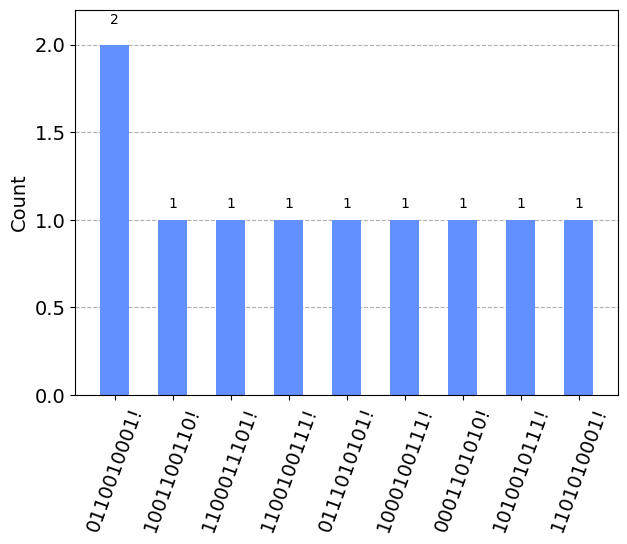

In [19]:
plot_histogram(newcounts, sort='value_desc')

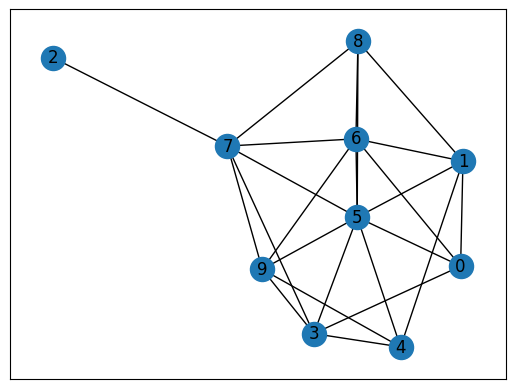

In [20]:
createGraph(GraphLaplacian)